In [1]:
import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

100%|██████████| 149M/149M [00:10<00:00, 15.4MB/s] 

Extracting model files...


In this notebook we will train a convolutional architecture in Pytorch to label brain MRI images with a type of malignancy of types:

glioma - meningioma - notumor - pituitary

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from typing import List, Tuple

from dataclasses import dataclass
import matplotlib.pyplot as plt
import random

In [20]:
@dataclass
class BrainTumorDataset(Dataset):
    root_dir: str
    transform: transforms.Compose = None
    
    def __post_init__(self):
        self.image_paths: List[str] = []
        self.labels: List[int] = []
        self.label_map = {
            'glioma': 0,
            'meningioma': 1,
            'notumor': 2,
            'pituitary': 3
        }
        self.label_map_inv = {v: k for k, v in self.label_map.items()}
        self._load_data()
    
    def _load_data(self):
        for class_name, label in self.label_map.items():
            class_folder = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    image_path = os.path.join(class_folder, filename)
                    if os.path.isfile(image_path):
                        self.image_paths.append(image_path)
                        self.labels.append(label)
    
    def __len__(self): 
        return len(self.image_paths)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def plot_random_images(self, num_images=4):
        """Plot a random sample of images with their labels."""
        fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
        
        random_indices = random.sample(range(len(self)), num_images)
        
        for i, idx in enumerate(random_indices):
            image, label = self[idx]
            
            if self.transform:
                image = self.denormalize_image(image)
            
            ax = axes[i]
            ax.imshow(image.permute(1, 2, 0))
            ax.set_title(f"Label: {self.label_map_inv[label]}")
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def denormalize_image(image):
        """Denormalize the image for visualization"""
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return image * std + mean

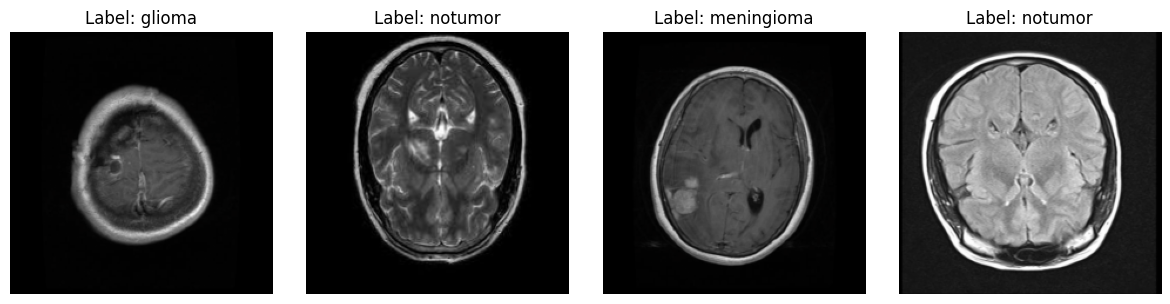

In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = BrainTumorDataset(root_dir='data\\brain-tumor-mri-dataset/training', transform=transform)
dataset.plot_random_images(num_images=4)

'c:\\Users\\gouwenss\\programming\\deeplearning'